In [2]:
import numbers

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch import nn
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import genericpath
import json
from sklearn.metrics import f1_score

np.random.seed(17)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# force working on cpu due to memory limitation
#device = torch.device("cpu")


def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result


class YogaPoseDataset(Dataset):

    def __init__(self, root, train, size=(256, 192), transform=None, example_images=None):
        root = root
        subdir = "train" if train else "test"
        self.data_path = os.path.join(root,subdir)
        self.size = size
        self.transform = transform
        # call to init the data
        self._init_data()

    def _init_data(self):
        images = list()

        for _, directory_class in enumerate(os.listdir(self.data_path)):
            class_path = os.path.join(self.data_path, directory_class)
            for file_name in os.listdir(class_path):
                f = cv2.imread(os.path.join(class_path, file_name), cv2.IMREAD_COLOR)

                f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)

                if self.transform is not None:
                    f = self.transform(f)

                data = torch.reshape(torch.FloatTensor(f), (3, self.size[0], self.size[1]))

                # format example  images[x][0] -> (label, input)
                # format example  images[x][1] -> [other information]
                # images[x] -> ((class_id, image_tensor), [filename])
                images.append((int(directory_class), data))


        np.random.shuffle(images,)
        self.images = images

    def __len__(self):
        # returns the number of samples in our dataset
        return len(self.images)

    def getData(self):
        return self.images

    def __getitem__(self, idx):
        """

        Args:
            idx: the index of the sample

        Returns: a tuple (class, input) for the given sample

        """
        return self.images[idx]

    def collate_fn(self, data):
        #print(data)
        Xs = torch.stack([x[1] for x in data])
        y = torch.stack([torch.tensor(x[0]) for x in data])
        return Xs, y

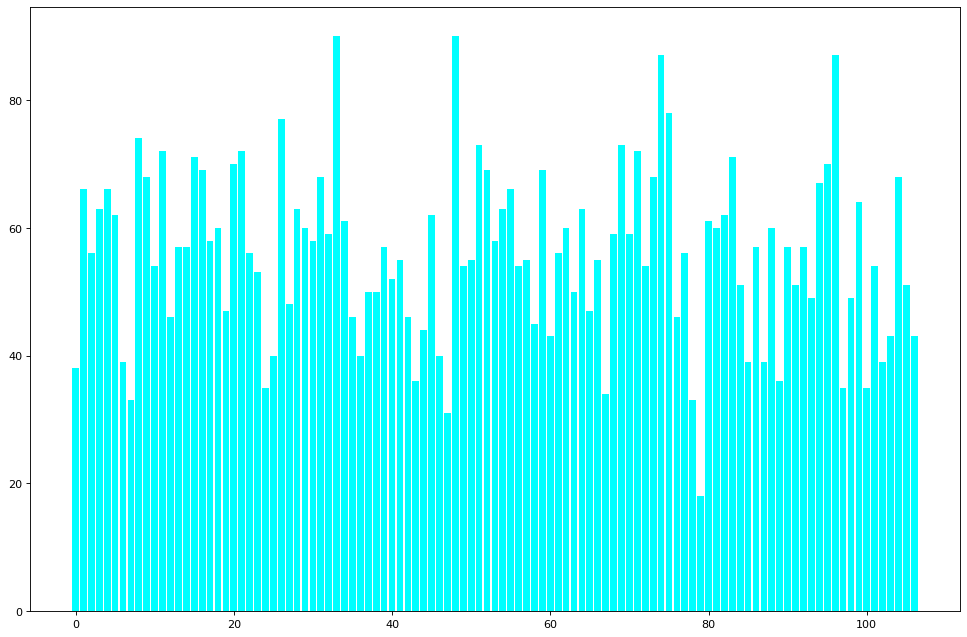

In [11]:
#DATASET ANALYSIS
with open("/home/orlando/PycharmProjects/YogaPose/data/annotations/annotation.json") as f:
    datalsit = []
    data = json.load(f)
    for i,v in data.items():
        datalsit.append(len(v["images_list"]))
# Iterating through the json
# list


bins = list(range(107))
plt.figure(figsize=(15, 10), dpi=80)
plt.bar(bins, datalsit, width = 0.85, color="cyan" )
plt.savefig("out/data_histogram.png")
plt.show()


In [60]:
data_aug_parameters = {
    "RC_size": 32, "RC_padding": 2,  # default = none
    "CJ_brightness": 50,  # default = 0
    "CJ_contrast": 0,  # default = 0
    "CJ_saturation": 0,  # default = 0
    "CJ_hue": 0,  # default = 0
    "P_padding": 3, "P_type": "constant",  # default = constant
    "HF_p": 0.5, "VF_p": 0.5, "RR_degrees": 60, "RG_p": 0.2}

data_aug_transform = [transforms.ToPILImage()]
norm_transform = transforms.Compose(data_aug_transform + [transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
DATASET_PATH = './data/split/'
ANNOTATION_PATH = './data/annotations/'
MODEL_NAME = "tpr_a4_256x192"
testset = YogaPoseDataset(DATASET_PATH,train=False, transform=test_transform)
trainset = YogaPoseDataset(DATASET_PATH,train=True, transform=norm_transform)
valset = trainset[(len(trainset)//10)*9:]
trainset = trainset[:(len(trainset)//10)*9]

In [61]:
# get model from torch hub
assert MODEL_NAME in ["tpr_a4_256x192", "tph_a4_256x192"]

transpose_model = torch.hub.load('yangsenius/TransPose:main', MODEL_NAME, pretrained=True)
transpose_model.to(device)

>>Load pretrained weights from url: https://github.com/yangsenius/TransPose/releases/download/Hub/tp_r_256x192_enc4_d256_h1024_mh8.pth
Successfully loaded model  (on cpu) with pretrained weights!


Using cache found in /home/orlando/.cache/torch/hub/yangsenius_TransPose_main
/home/orlando/.cache/torch/hub/yangsenius_TransPose_main/lib/models/transpose_r.py:333: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = temperature ** (2 * (dim_t // 2) / one_direction_feats)


TransPoseR(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [62]:
from TransPose.lib.config import cfg
from TransPose.lib.utils import transforms
from TransPose.lib.core.inference import get_final_preds
from TransPose.visualize import inspect_atten_map_by_locations

In [63]:
class PoseClassifier(nn.Module):
    def __init__(self, n_class,
                 transpose_model,device=device, fine_tune=False, pretrained=True):
        super(PoseClassifier, self).__init__()
        layers = []
        dropout = 0.5
        hidden_layers = [128, 512, 512, 512, 512, 256, 128, 128]
        self.tpr = transpose_model
        layers.append(nn.Conv2d(17, 128, 3, padding=1))
        self.relu = nn.ReLU()


        self.dropout = nn.Dropout(dropout)
        self.conv1 = nn.Conv2d(17, hidden_layers[0], 3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_layers[0])
        self.pool1 = nn.MaxPool2d((2, 2), 2)

        self.pool2 = nn.MaxPool2d((3, 3), 3)
        self.conv2 = nn.Conv2d(hidden_layers[0], hidden_layers[1], 3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_layers[1])
        self.conv3 = nn.Conv2d(hidden_layers[1], hidden_layers[2], 3, padding=1)
        self.bn3 = nn.BatchNorm2d(hidden_layers[2])
        self.conv4 = nn.Conv2d(hidden_layers[2], hidden_layers[3], 3, padding=1)
        self.bn4 = nn.BatchNorm2d(hidden_layers[3])
        self.conv5 = nn.Conv2d(hidden_layers[3], hidden_layers[4], 3, padding=1)
        self.bn5 = nn.BatchNorm2d(hidden_layers[4])

        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(hidden_layers[4],hidden_layers[-1])
        self.classifier = nn.Linear(hidden_layers[-1],n_class)



    def forward(self, x):
        out = self.tpr(x)
        #print(out.size(),"AFTER TPH")
        out = self.conv1(out)
        out = self.bn1(out)
        #print(out.size(),"AFTER CONV1")
        out = self.pool1(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv2(out)
        out = self.bn2(out)
        #print(out.size(),"AFTER CONV2")
        out = self.pool1(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv3(out)
        out = self.bn3(out)
        #print(out.size(),"AFTER CONV3")
        out = self.pool2(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv4(out)
        out = self.bn4(out)
        #print(out.size(),"AFTER CONV4")
        out = self.pool2(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv5(out)
        out = self.bn5(out)
        #print(out.size(),"AFTER CONV5")
        #out = self.pool1(out)
        out = self.flatten(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.lin1(out)
        '''
        out = self.pool1(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER POOL")
        out = self.conv6(out)

        #print(out.size(),"AFTER CONV6")
        '''


        out = self.flatten(out)
        out = self.relu(out)
        out = self.dropout(out)
        #print(out.size(),"AFTER FLATTEN")

        out = self.classifier(out)
        return out

In [64]:
num_classes = 107
num_epochs = 100
batch_size = 12
learning_rate = 0.0001
learning_rate_decay = 0.99

model = PoseClassifier(n_class=num_classes, transpose_model=transpose_model)
model.to(device)
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=False,collate_fn=testset.collate_fn)
val_loader = torch.utils.data.DataLoader(dataset=valset,batch_size=batch_size,shuffle=False,collate_fn=testset.collate_fn)
test_loader = torch.utils.data.DataLoader(dataset=testset,batch_size=batch_size,shuffle=False,collate_fn=testset.collate_fn)


fine_tune = False
if fine_tune:
    params_to_update = []
    for param in model.tpr.parameters():
        param.requires_grad = False
    for p in model.parameters():
        if p.requires_grad == True:
            params_to_update.append(p)
else:
    params_to_update = model.parameters()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [65]:
print(len(train_loader))
len(train_loader.dataset)

372


4455

In [66]:
# Train the model

#best_model = type(model)(num_classes, fine_tune, pretrained) # get a new instance
def train(model,num_epochs=num_epochs,lr=learning_rate):
    total_step = len(train_loader)
    loss_train = []
    loss_val = []
    best_accuracy = None
    accuracy_val = []
    accuracy_test = []

    train_f1 = []
    val_f1 = []
    for epoch in range(num_epochs):
        train_predicts = torch.tensor([]).to(device)
        train_labels = torch.tensor([]).to(device)
        val_predicts = torch.tensor([]).to(device)
        val_labels = torch.tensor([]).to(device)
        model.train()
        correct = 0
        total = 0
        loss_iter = 0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print(outputs,labels)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_iter += loss.item()


            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

            train_predicts = torch.cat((train_predicts, predicted), dim=0)
            train_labels = torch.cat((train_labels, labels), dim=0)

        accuracy = 100 * correct / total
        accuracy_test.append(accuracy)
        loss_train.append(loss_iter / (len(train_loader) * batch_size))
        print('Training accuracy is: {} %'.format(accuracy))
        train_labels = train_labels.cpu().numpy()
        train_predicts = train_predicts.cpu().numpy()
        f1 =f1_score(train_labels, train_predicts, average='weighted')
        f1 = f1 * 100
        train_f1.append(f1)
        print('Training F1 is: {} %'.format(f1))

        # Code to update the lr
        lr *= learning_rate_decay
        update_lr(optimizer, lr)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            loss_iter = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                loss_iter += loss.item()
                val_predicts = torch.cat((val_predicts, predicted), dim=0)
                val_labels = torch.cat((val_labels, labels), dim=0)
            loss_val.append(loss_iter / (len(val_loader) * batch_size))
            accuracy = 100 * correct / total
            accuracy_val.append(accuracy)
            print('Validation accuracy is: {} %'.format(accuracy))
            val_labels = val_labels.cpu().numpy()
            val_predicts = val_predicts.cpu().numpy()
            f1 =f1_score(val_labels, val_predicts, average='weighted')
            f1 = f1 * 100
            val_f1.append(f1)
            print('Validation F1 is: {} %'.format(f1))
            print("--------------------- NEXT EPOCH ---------------------")
            early_stop = True
            patience = 3
            if epoch > patience - 1:
                for j in range(patience - 1):
                    if max(accuracy_val) > list(reversed(accuracy_val))[j]:
                        if "not_improving_epochs" in locals():
                            not_improving_epochs += 1
                        else:
                            not_improving_epochs = 1
                        print('Not saving the model')
                    else:
                        not_improving_epochs = 0
                        best_model = model
                        print("Saving the model")
                        break
                    if not_improving_epochs >= patience:
                        early_stop = True
                        print('Early stopping')
                        break
                    break

    plt.figure(2)
    plt.plot(loss_train, 'r', label='Train loss')
    plt.plot(loss_val, 'g', label='Val loss')
    plt.legend()
    plt.show()

    plt.figure(3)
    plt.plot(accuracy_val, 'r', label='Val accuracy')
    plt.legend()
    plt.show()
    return {"Loss/train": loss_train, "Loss/val": loss_val, "Accuracy/train":accuracy_val, "Accuracy/val": accuracy_test, "F1/train": train_f1, "F1/val": val_f1}

def test(model):
    model.eval()
    with torch.no_grad():
            all_preds = torch.tensor([]).to(device)
            all_labels = torch.tensor([]).to(device)
            correct = 0
            total = 0
            loss_iter = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                loss_iter += loss.item()
                all_preds = torch.cat((all_preds, predicted), dim=0)
                all_labels = torch.cat((all_labels, labels), dim=0)

            loss_test =(loss_iter / (len(test_loader) * batch_size))
            accuracy = 100 * correct / total

            all_preds = all_preds.cpu().numpy()
            all_labels = all_labels.cpu().numpy()
            f1 =  f1_score(all_labels, all_preds, average='weighted')
            f1 = f1 * 100
            print('Test accuracy is: {} %'.format(accuracy))
            print('Test f1 is: {} %'.format(f1))
            print('Test Loss: {:.4f}'.format(loss_test))
    return all_preds, all_labels, {"Accuracy/test": accuracy, "Loss/test": loss_test, "F1/test" : f1}

In [68]:
model.load_state_dict(torch.load("out/logs/15_Dec[21-38-49]/model.ckpt"))
test_predicted, test_labels , test_values = test(model)

Test accuracy is: 66.41074856046065 %
Test f1 is: 66.29739947072856 %
Test Loss: 0.1908


In [58]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_true = test_labels
y_pred = test_predicted
target_names = [str(x) for x in range(107)]

print(target_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106']


In [124]:
txt = (classification_report(y_true, y_pred, target_names=target_names, digits=4))
print(txt)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        11
           1     0.8462    0.9167    0.8800        12
           2     0.5385    0.6364    0.5833        11
           3     0.3636    0.4444    0.4000         9
           4     0.8750    0.5833    0.7000        12
           5     0.7000    0.8750    0.7778         8
           6     1.0000    0.5833    0.7368        12
           7     0.5714    0.6667    0.6154         6
           8     1.0000    0.6364    0.7778        11
           9     0.8462    0.7857    0.8148        14
          10     0.6923    1.0000    0.8182         9
          11     0.8333    0.5556    0.6667         9
          12     0.7500    0.9000    0.8182        10
          13     0.6667    0.5000    0.5714        12
          14     0.5000    0.2500    0.3333        12
          15     0.5455    0.7500    0.6316         8
          16     1.0000    0.8000    0.8889        15
          17     0.8667    

/home/orlando/anaconda3/envs/AML_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orlando/anaconda3/envs/AML_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/orlando/anaconda3/envs/AML_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

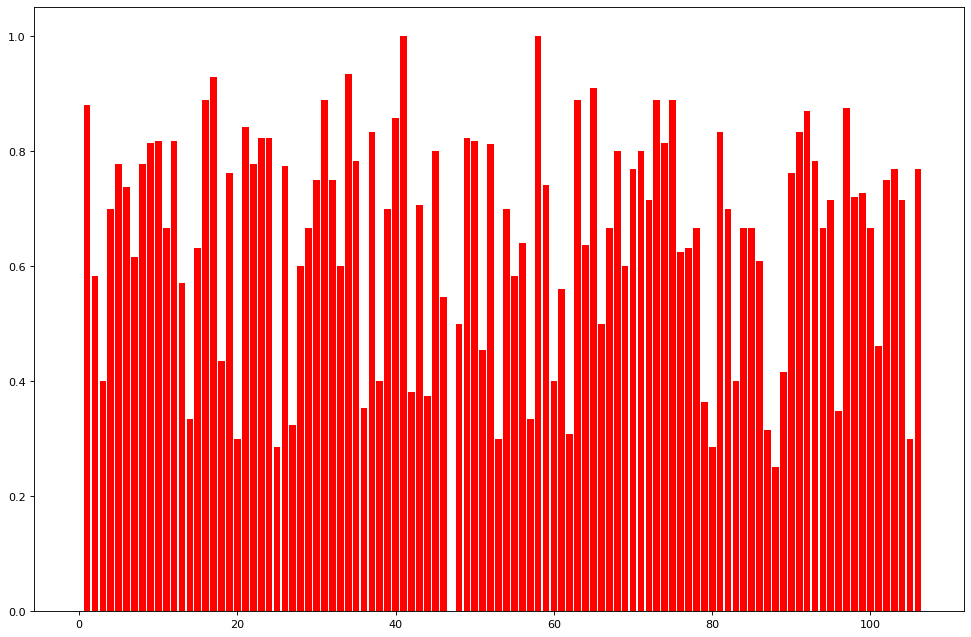

In [122]:
def f1_ist(txt=txt):
    f1list = []
    for line in txt.splitlines():
        if len(line.split()) > 3:
            if line.split()[3][0] in ["0", "1"]:

                f1list.append(float(line.split()[3]))
    return f1list [:-2]

f1list = f1_ist(txt)
bins = list(range(107))
plt.figure(figsize=(15, 10), dpi=80)
plt.bar(bins, f1list, width = 0.85, color="red" )
plt.savefig("out/histogram.jpg")
plt.show()
